### Exercise 00:

Trading latent factor portfolios: PCA ("Shrinking the Cross-section") and others: PPCA, VAE.

In [1]:
from load_portfolios import *

In [2]:
filename = './data/managed_portfolios_anom_d_55.csv'
dropna_perc = 0.5 # could be 1, which leads to 41; if 0.5, leads to 55 (all)
dates_anomaly, re_anomaly, mkt_anomaly, names_anomaly = load_managed_portfolios(filename, drop_perc=dropna_perc)

tT0 = '2019-01-01'
# to strftime
tT0 = pd.to_datetime(tT0)
freq = 252 # daily freq

re_anomaly.index = dates_anomaly.values
mkt_anomaly.index = dates_anomaly.values
mkt0 = mkt_anomaly.copy()

r0, _ = demarket(re_anomaly.loc[:tT0, :], mkt0.loc[:tT0])
r0 = r0.divide(r0.std(axis=0), axis=1).multiply(mkt0.std())
T, n = r0.shape
y = np.mean(r0, axis=0)

#### PCA

In [129]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X0 = scaler.fit_transform(r0)

In [130]:
from sklearn.decomposition import PCA
import itertools

def get_pca_factors(r0, k):
    """Fit PCA with k components to r0 and return the fitted model and the T x k factors."""
    pca = PCA(n_components=k)
    factors = pca.fit_transform(r0)
    return pca, factors

# Fit 6-factor PCA
pca6, factors6 = get_pca_factors(X0, 6)  # factors6: T x 6, columns are f1, f2, ..., f6

# Generate all combinations of factors
def get_factor_combinations(factors, max_k=10):
    """Return a dict of all non-empty combinations of columns from factors (T x max_k)."""
    T, k = factors.shape
    comb_dict = {}
    for n in range(1, k+1):
        for idx_tuple in itertools.combinations(range(k), n):
            key = tuple(idx+1 for idx in idx_tuple)  # e.g., (1,2) for f1,f2
            comb_dict[key] = factors[:, idx_tuple]
    return comb_dict

factor_combinations = get_factor_combinations(factors6, max_k=10)

# Example: factor_combinations[(1,)] is just f1, factor_combinations[(1,2)] is f1 and f2, etc.
# There are 63 combinations in total (sum_{n=1}^{6} C(6,n))

In [131]:
print(f'Number of factor combinations: {len(factor_combinations)}')

Number of factor combinations: 63


In [132]:
from sklearn.linear_model import LinearRegression

# Prepare to store results
results = []
factor_keys = list(factor_combinations.keys())
anom_names = r0.columns.tolist()  # 55 anomaly names
# Assign X0 the column names and indices of r0
X0 = pd.DataFrame(X0, index=r0.index, columns=r0.columns)

# For each factor combination (X), regress each anomaly (y) on X, store R^2
for key in factor_keys:
    X = factor_combinations[key]  # shape: T x d
    n_factors = len(key)
    for j, anom in enumerate(anom_names):
        y = X0.loc[:tT0, anom].values  # align with r0 index
        # Remove any NaNs (if any) for regression
        mask = ~np.isnan(y)
        X_valid = X[mask]
        y_valid = y[mask]
        if X_valid.shape[0] > 0 and y_valid.shape[0] > 0:
            reg = LinearRegression().fit(X_valid, y_valid)
            r2 = reg.score(X_valid, y_valid)
        else:
            r2 = np.nan
        results.append({
            'factor_combination': key,
            'num_factors': n_factors,
            'anomaly': anom,
            'r2': r2
        })

# Convert to DataFrame
r2_df = pd.DataFrame(results)[['factor_combination','num_factors','anomaly','r2']]

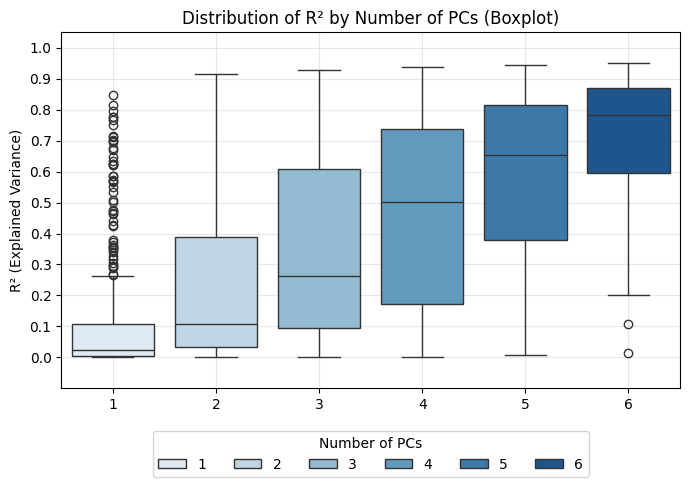

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
# Use a blue gradient palette and assign hue to num_factors for color mapping
palette = sns.color_palette('Blues', n_colors=6)
sns.boxplot(data=r2_df, x='num_factors', y='r2', hue='num_factors', palette=palette, showfliers=True, dodge=False)
# Ignore x-axis grid lines and remove x-axis labels
plt.xlabel(None)
plt.ylabel('R² (Explained Variance)')
plt.title('Distribution of R² by Number of PCs (Boxplot)')
plt.grid(True, alpha=0.3)
plt.xticks([0,1,2,3,4,5],[1,2,3,4,5,6])
plt.ylim(-0.1, 1.05)
plt.yticks(np.arange(0, 1.1, 0.1))
# Move legend below the plot
plt.legend(title='Number of PCs', loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6, frameon=True)
plt.tight_layout()
plt.show()

In [134]:
# Calculate PCA reconstruction errors and explained variances for 1-6 PCs (with standardization and inverse transform)
recon_errors = []
explained_variances = []
for k in range(1, 7):   
    scaler = StandardScaler()
    X0 = scaler.fit_transform(r0)
    pca = PCA(n_components=k)
    X_proj = pca.fit_transform(X0)
    X_hat_std = pca.inverse_transform(X_proj)
    X_hat = scaler.inverse_transform(X_hat_std)  # scale back to original units
    # Reconstruction error: mean squared error averaged across columns (features)
    mse_per_col = ((r0.values - X_hat)**2).mean(axis=0)
    mse_avg = mse_per_col.mean()    
    recon_errors.append(mse_avg)
    # Explained variance ratio (sum for first k PCs)
    explained_variances.append(pca.explained_variance_ratio_.sum())

# Display results
print('Reconstruction errors (MSE, avg across columns) for 1-6 PCs:', recon_errors)
print('Explained variance ratios for 1-6 PCs:', explained_variances)

Reconstruction errors (MSE, avg across columns) for 1-6 PCs: [np.float64(7.409191723432332e-05), np.float64(5.9764850926436e-05), np.float64(4.842152112643548e-05), np.float64(4.3181969760787507e-05), np.float64(3.8159782833036755e-05), np.float64(3.360902966844683e-05)]
Explained variance ratios for 1-6 PCs: [np.float64(0.341160832121911), np.float64(0.4685597819232793), np.float64(0.5694267893562704), np.float64(0.6160178588096447), np.float64(0.6606760830791432), np.float64(0.7011422302662224)]


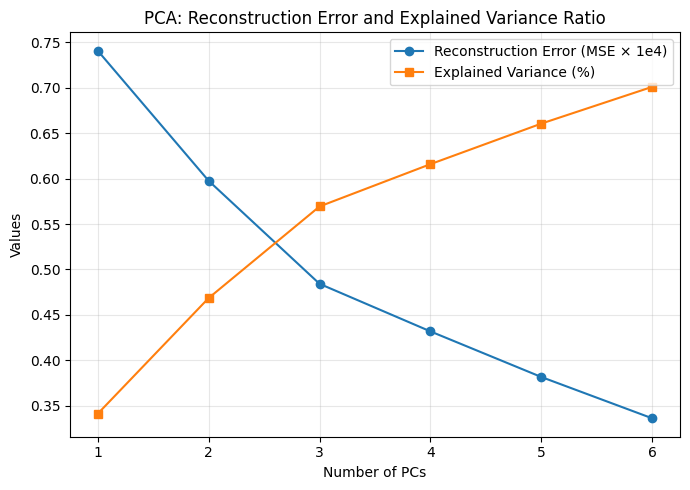

In [135]:
# Plot scaled reconstruction errors and explained variance ratios for 1-6 PCs
plt.figure(figsize=(7,5))
x = np.arange(1, 7)
plt.plot(x, np.array(recon_errors)*1e4, marker='o', color='tab:blue', label='Reconstruction Error (MSE × 1e4)')
plt.plot(x, explained_variances, marker='s', color='tab:orange', label='Explained Variance (%)')
plt.xlabel('Number of PCs')
plt.ylabel('Values')
plt.title('PCA: Reconstruction Error and Explained Variance Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(x)
plt.tight_layout()
plt.show()

### VAE

In [10]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

# Standardize r0 before VAE
scaler = StandardScaler()
X_std = scaler.fit_transform(r0)
X_tensor = torch.tensor(X_std, dtype=torch.float32)

In [11]:
# VAE: Two hidden layers (with ReLU) in both encoder and decoder
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        # Encoder: two hidden layers with ReLU
        self.fc_enc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc_enc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)
        # Decoder: two hidden layers with ReLU
        self.fc_dec1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc_dec2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc_dec3 = nn.Linear(hidden_dim1, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc_enc1(x))
        h2 = torch.relu(self.fc_enc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h1 = torch.relu(self.fc_dec1(z))
        h2 = torch.relu(self.fc_dec2(h1))
        return self.fc_dec3(h2)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

In [ ]:
# Instantiate model
input_dim = X_tensor.shape[1]
latent_dim = 6
vae = VAE(input_dim, latent_dim)

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# Seed for reproducibility
torch.manual_seed(42)

# Training loop
n_epochs = 1000
vae.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    x_recon, mu, logvar, z = vae(X_tensor)
    recon_loss = nn.functional.mse_loss(x_recon, X_tensor, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = recon_loss + kl_loss
    loss.backward()
    optimizer.step()
    if (epoch+1) % 200 == 0 and epoch == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, KL Loss: {kl_loss.item():.4f}')

KeyboardInterrupt: 

In [ ]:
# After training, extract latent factors z (mean of encoder) and reconstruct
vae.eval()
with torch.no_grad():
    z_latent, _ = vae.encode(X_tensor)
    z_latent = z_latent.numpy()  # shape: (T, 6)
    x_recon, _, _, _ = vae(X_tensor)
    X_recon_std = x_recon.numpy()
    X_recon = scaler.inverse_transform(X_recon_std)  # scale back to r0 units

# Compare reconstruction to original r0
mse_per_col = ((r0.values - X_recon)**2).mean(axis=0)
mse_avg = mse_per_col.mean()
print(f'VAE reconstruction error (MSE, avg across columns, original scale): {mse_avg:.6g}')

VAE reconstruction error (MSE, avg across columns, original scale): 6.65808e-05


In [ ]:
z_latent # should be (T, 6)

array([[-1.2539290e-01,  1.3896289e-02,  4.5061389e-01,  1.5693825e-02,
         1.0674976e-01, -3.5970382e-02],
       [ 4.4166118e-02,  1.1726805e-02,  4.3153889e-02,  2.6767908e-02,
         2.4714068e-02, -1.1795610e-02],
       [ 1.2052119e-02,  2.6976876e-03,  1.3641700e-01,  2.4208533e-02,
         9.0380743e-02,  4.2727217e-04],
       ...,
       [ 2.6664528e-01,  1.4161595e-02, -8.2765959e-02,  1.8765889e-02,
        -1.6192558e-01,  1.7033048e-02],
       [ 2.6772022e-03,  9.4839502e-03, -1.6131511e-01,  2.3114812e-02,
         6.4362422e-02, -6.0501732e-03],
       [ 1.4220098e-01,  1.0015045e-02, -7.6277114e-02,  2.3363892e-02,
        -2.1864399e-02,  1.2327429e-02]], shape=(9838, 6), dtype=float32)